In [1]:
import os
from glob import glob
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import mne
mne.set_log_level(verbose=False)

from Datasets import *

## Cargamos los datos con normalidad

In [2]:
BATCH_SIZE = 4
channels = ['F4', 'C3']

In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [5]:
path = "../Data/PSG1.edf"
test = EDFData_PTH(path, channels=channels, std=False)
testloader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, drop_last=True)

## Extraemos las etiquetas del objeto dataset

In [29]:
labels = []
for data, label in test:
    labels.append(label.item())

In [44]:
def plot_labels(y_pred, y_true, label_mapper=None):
    """
    Plots the labels. Useful to inspect transitions between sleep stages.

    Parameters
    ----------
    y_pred: 1D list-like iterable
    y_true: 1D list-like iterable
    label_mapper: dict{int:str}
        dictionary mapping label numbers to sleep stages' names.
    """
    plt.plot(y_true, label="True")
    plt.plot(y_pred, label="Pred")
    if label_mapper:
        plt.yticks(list(label_mapper.keys()), list(label_mapper.values()))
    plt.legend()


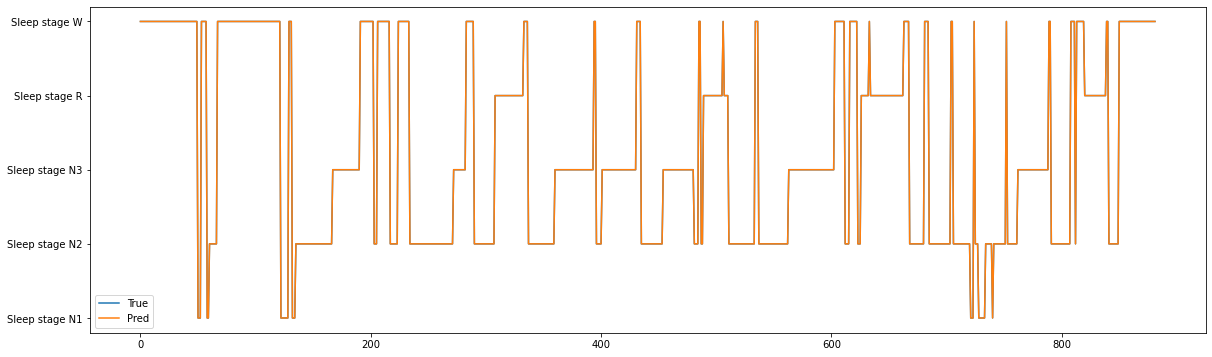

In [45]:
plt.figure(figsize=(20,6))
plot_labels(labels, labels, test.id_to_class_dict)
plt.show()

## Definimos un modelo para probar a predecir las etiquetas

In [47]:
sampling_rate = int(test.sampling_rate)
sampling_rate

512

In [62]:
class TinySleepNet(nn.Module):
    def __init__(self, sampling_rate, channels, classes):
        super(TinySleepNet, self).__init__()
        self.sampling_rate = sampling_rate
        self.channels = channels
        self.classes = classes

        self.feature_extraction = nn.Sequential(*[
            nn.Conv1d(in_channels=len(channels), out_channels=128, kernel_size=sampling_rate//2, stride=sampling_rate//4),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=8, stride=8),
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=8, stride=1, padding=3),
            nn.ReLU(),
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=8, stride=1, padding=3),
            nn.ReLU(),
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=8, stride=1, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4)
        ])

        self.lstm = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        
        self.classifier = nn.Linear(128, classes)

    def forward(self, X):
        X = self.feature_extraction(X)
        X, _ = self.lstm(X.permute(0,2,1))
        X = X[:,-1,:]
        X = self.classifier(X.reshape(X.shape[0],-1))
        return X

## Obtenemos las etiquetas predichas para todo el dataset

In [79]:
preds = []
for X, Y in testloader:
    X = X.to(device).float()
    with torch.no_grad():
        pred = model(X)
        pred = pred.softmax(-1).argmax(-1)
        preds.extend(pred.cpu().numpy())

In [63]:
model = TinySleepNet(sampling_rate, channels, classes=len(test.id_to_class_dict))
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()
model

TinySleepNet(
  (feature_extraction): Sequential(
    (0): Conv1d(2, 128, kernel_size=(256,), stride=(128,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(128, 128, kernel_size=(8,), stride=(1,), padding=(3,))
    (4): ReLU()
    (5): Conv1d(128, 128, kernel_size=(8,), stride=(1,), padding=(3,))
    (6): ReLU()
    (7): Conv1d(128, 128, kernel_size=(8,), stride=(1,), padding=(3,))
    (8): ReLU()
    (9): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 128, batch_first=True)
  (classifier): Linear(in_features=128, out_features=5, bias=True)
)

## Matriz de transiciones

Principalmente tenemos que recorrer todas las etiquetas y contar la cantidad de veces que pasa de una a la siguiente

In [104]:
transitions = {}
for initial, final in zip(labels, labels[1:]):
    initial, final = int(initial), int(final)
    # print(f"{test.id_to_class_dict[initial]} --> {test.id_to_class_dict[final]}")
    transition = (initial, final)
    if transition in transitions.keys():
        transitions[transition] += 1
    else:
        transitions[transition] = 1
    # break

In [106]:
len(transitions)

18

In [100]:
transitions_matrix = np.zeros(shape=(len(test.id_to_class_dict),len(test.id_to_class_dict)))
transitions_matrix.shape

(5, 5)

In [108]:
for idx, reps in transitions.items():
    transitions_matrix[idx[0],idx[1]] = reps

In [119]:
def plot_heatmaps_raw(data, threshold = None, precision = 1, cmap='magma'):    
    """
    Generate a heatmap from a matrix of data (can be a dataframe as well).
    Doesn't include ticks on axis.

    Arguments:
    data -> np.array / pd.DataFrame
    threshold -> float
        Threshold used to change the font color.
    precision -> float
        Float numbers precision.
    Returns:
    None
    """
    
    plt.matshow(data, cmap=cmap, fignum = 0, aspect = "auto")

    if not threshold:
        threshold = ((np.max(data) + np.min(data))/2).mean()
        
    for (i, j), z in np.ndenumerate(data):
        if z < threshold:
            color = 'w'
        else:
            color = 'k'

        plt.text(j, i, f"{z:0.{precision}f}", ha = "center", va = "center", color = color)

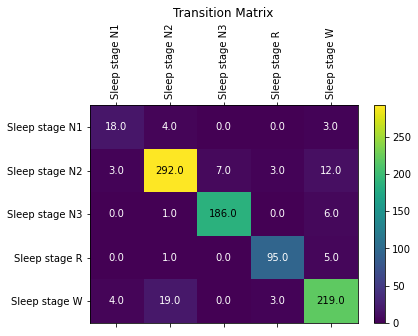

In [127]:
plt.figure()
plt.title("Transition Matrix")
plot_heatmaps_raw(transitions_matrix, cmap='viridis')
plt.xticks(range(len(test.id_to_class_dict)), list(test.id_to_class_dict.values()), rotation=90)
plt.yticks(range(len(test.id_to_class_dict)), list(test.id_to_class_dict.values()), rotation=0)
plt.colorbar()
plt.show()